# Tesla Stock Prediction

#  Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')




In [ ]:
df = pd.read_csv("/content/AMZN.csv")

In [ ]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000
1,1,1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000
2,2,1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000
3,3,1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000
4,4,1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000


In [ ]:
df.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
6830,6830,2024-07-09,199.399994,200.570007,199.050003,199.339996,32700100
6831,6831,2024-07-10,200.000000,200.110001,197.690002,199.789993,32883800
6832,6832,2024-07-11,200.089996,200.270004,192.860001,195.050003,44565000
6833,6833,2024-07-12,194.800003,196.470001,193.830002,194.490005,30554000
6834,6834,2024-07-15,194.542496,196.190002,190.830002,192.720001,38808123


# EDA

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)

In [ ]:
start_date = '2023-07-01'
end_date = '2024-07-15'
df = df[(df.index >= start_date) & (df.index <= end_date)][['Close']]

In [ ]:
df= df[["Close"]]

In [ ]:
df.head()

,Close
Date,
2023-07-03,130.220001
2023-07-05,130.380005
2023-07-06,128.360001
2023-07-07,129.779999
2023-07-10,127.129997


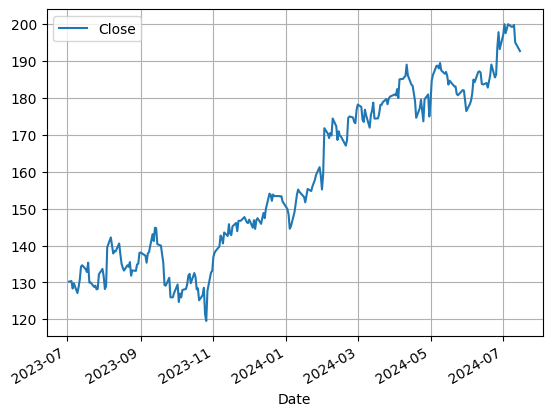

In [ ]:
df.plot()
plt.grid(True)

In [ ]:
# Test for stationarity
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(100).mean()
    rolstd = timeseries.rolling(100).std()

    # Plot rolling statistics
    plt.figure(figsize=(18, 8))
    plt.grid(True)
    plt.plot(timeseries, color='blue', label='Original', linewidth=3)
    plt.plot(rolmean, color='red', label='Rolling mean', linewidth=3)
    plt.plot(rolstd, color='black', label='Rolling std', linewidth=3)
    plt.legend(loc='best', fontsize=20, shadow=True, facecolor='lightpink')
    plt.title('Rolling mean and std', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show(block=False)

    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag="AIC")
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'Lags', 'Observations'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)


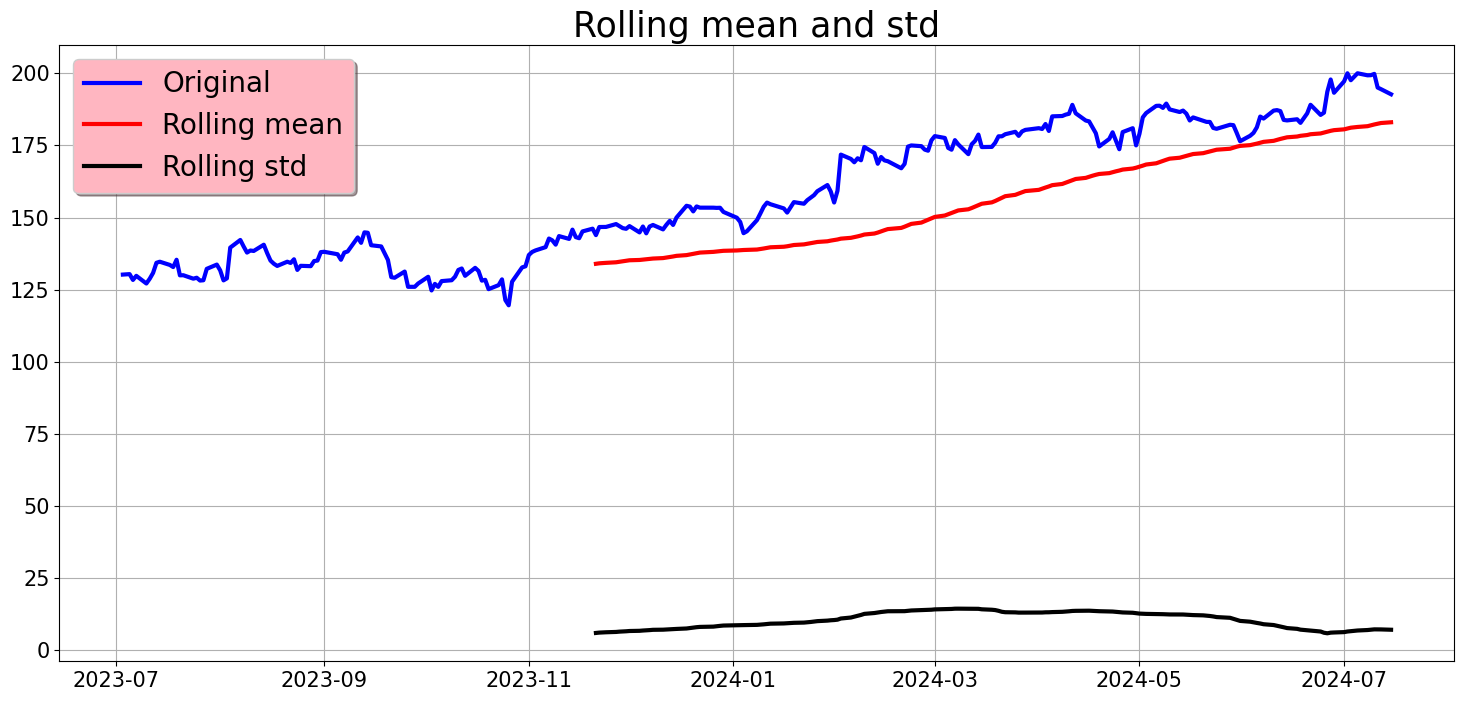

Results of Dickey-Fuller Test:
Test Statistics          -0.472900
p-value                   0.897197
Lags                      2.000000
Observations            257.000000
Critical Value (1%)      -3.456054
Critical Value (5%)      -2.872853
Critical Value (10%)     -2.572799
dtype: float64


In [ ]:
test_stationarity(df.Close)

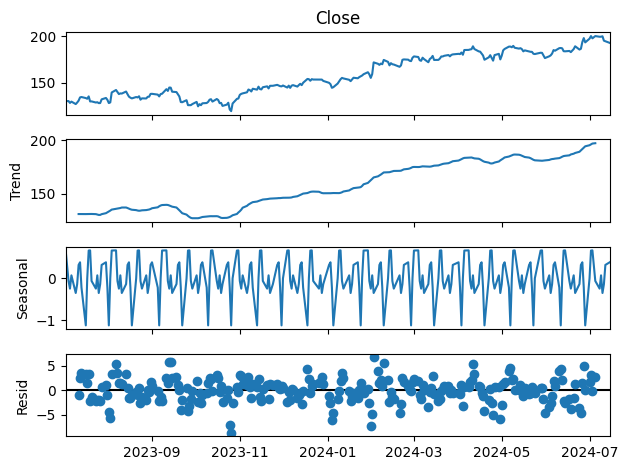

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'df' is your DataFrame and 'Close' is your time series column
result = seasonal_decompose(df['Close'], period=12)

# To plot the decomposition
import matplotlib.pyplot as plt

result.plot()
plt.show()


In [ ]:
result.seasonal

,seasonal
Date,
2023-07-03,0.669956
2023-07-05,-0.059945
2023-07-06,-0.242288
2023-07-07,0.074255
2023-07-10,-0.346704
...,...
2024-07-09,0.074255
2024-07-10,-0.346704
2024-07-11,-0.134475


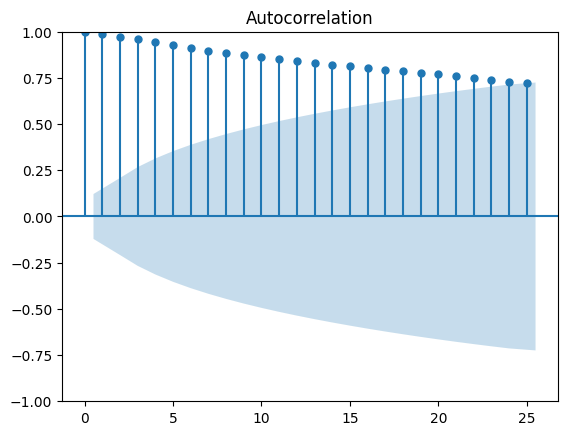

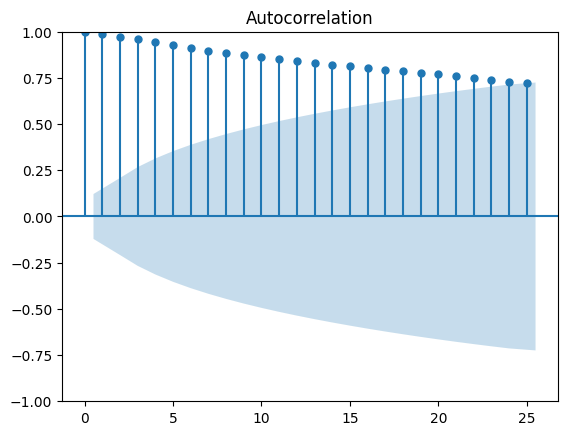

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df.Close)

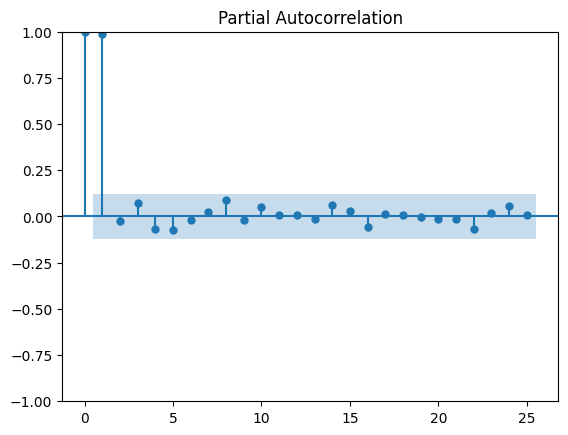

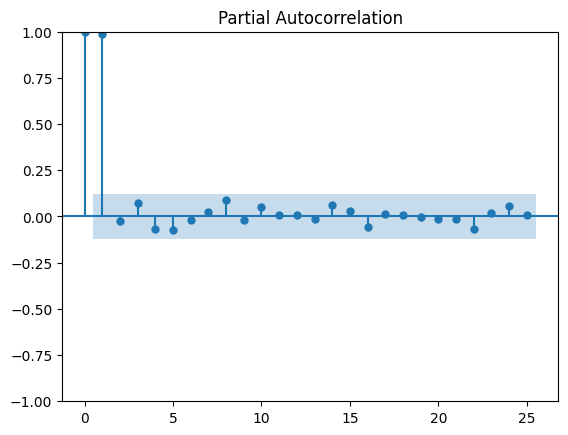

In [ ]:
plot_pacf(df.Close)

In [ ]:
df_stock = df['Close']


In [ ]:
df_close = df_stock.diff()

In [ ]:
df_close = df_close.dropna()

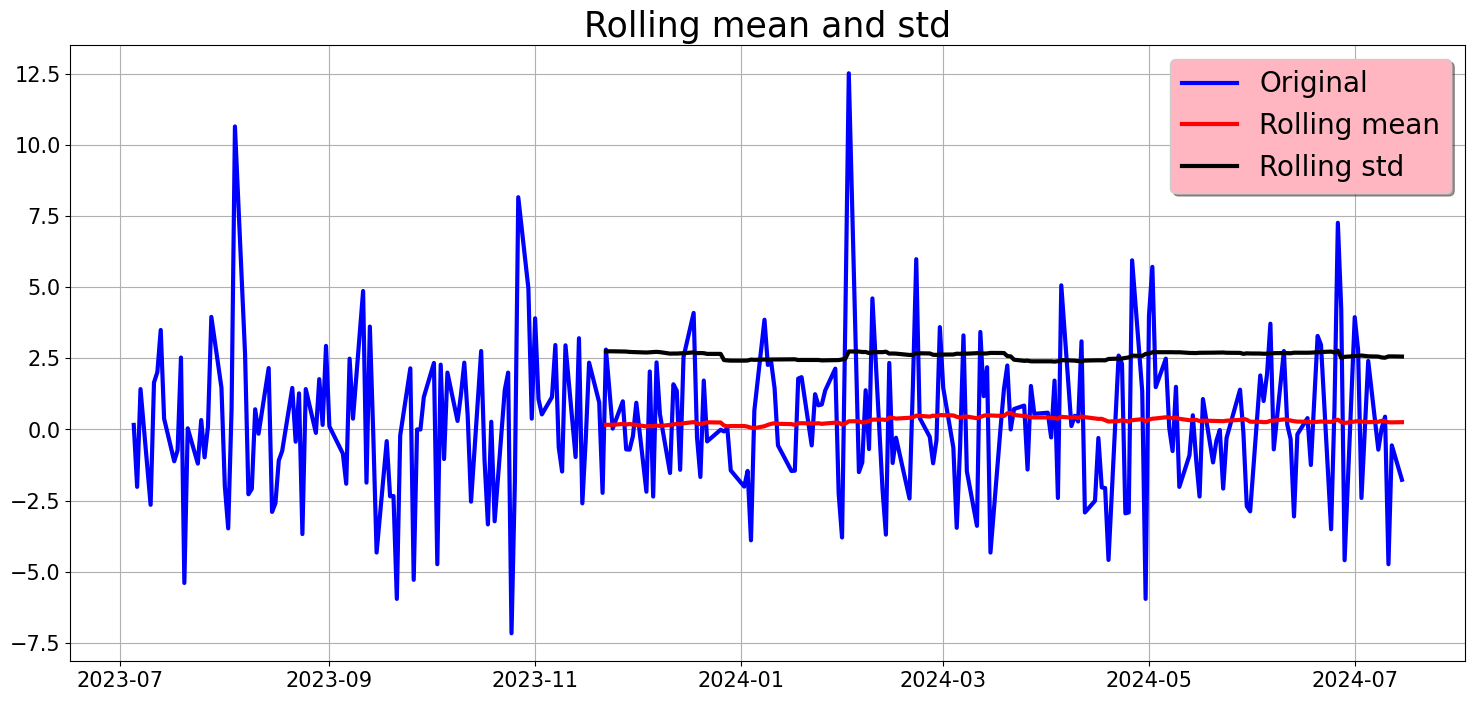

Results of Dickey-Fuller Test:
Test Statistics        -1.415841e+01
p-value                 2.101715e-26
Lags                    1.000000e+00
Observations            2.570000e+02
Critical Value (1%)    -3.456054e+00
Critical Value (5%)    -2.872853e+00
Critical Value (10%)   -2.572799e+00
dtype: float64


In [ ]:
test_stationarity(df_close)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2023-07-03 to 2024-07-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   260 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


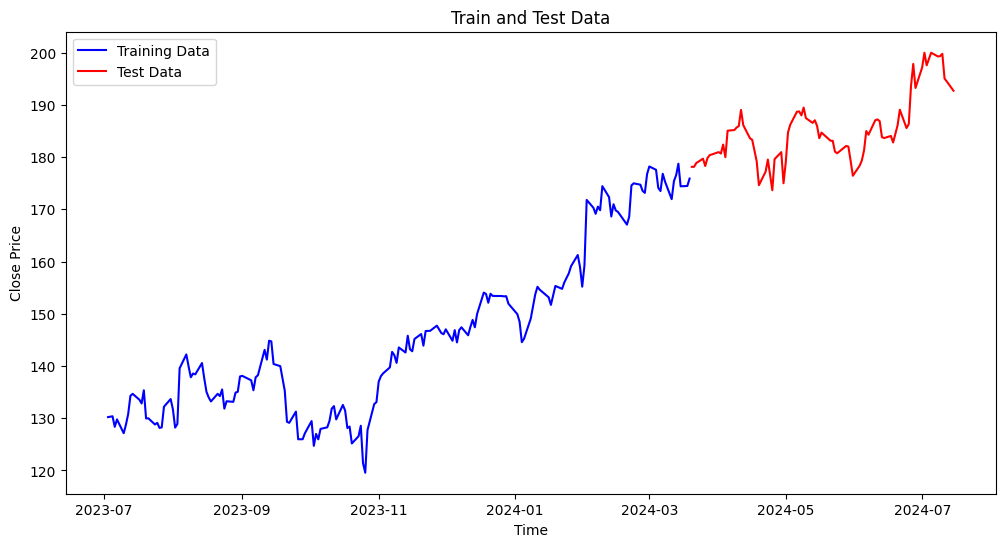

In [ ]:
# Create the train and test sets
train = df[['Close']][:180]
test = df[['Close']][180:]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Test Data', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Train and Test Data')
plt.legend()
plt.show()


In [ ]:
print(len(train), len(test))


180 80


In [ ]:
# Function to find the best ARIMA order based on RMSE and print all tested orders with RMSE
def best_arima_order(train, test, p_values, d_values, q_values):
    best_order = None
    best_rmse = float('inf')
    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(test))
                    rmse = sqrt(mean_squared_error(test, forecast))
                    results.append(((p, d, q), rmse))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                except Exception as e:
                    continue

    print("\nARIMA Results:")
    for order, rmse in results:
        print(f"ARIMA{order} - RMSE: {rmse}")

    return best_order, best_rmse

In [ ]:
# Function to find the best SARIMA order based on RMSE and print all tested orders with RMSE
def best_sarima_order(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    best_order = None
    best_rmse = float('inf')
    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                try:
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
                                    model_fit = model.fit(disp=False)
                                    forecast = model_fit.get_forecast(steps=len(test)).predicted_mean
                                    rmse = sqrt(mean_squared_error(test, forecast))
                                    results.append(((p, d, q, P, D, Q, m), rmse))
                                    if rmse < best_rmse:
                                        best_rmse = rmse
                                        best_order = (p, d, q, P, D, Q, m)
                                except Exception as e:
                                    continue

    print("\nSARIMA Results:")
    for order, rmse in results:
        print(f"SARIMA{order} - RMSE: {rmse}")

    return best_order, best_rmse



In [ ]:
# Define ranges for p, d, q for ARIMA and SARIMA
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

In [ ]:
# Seasonal parameters for SARIMA
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
m_values = [12]  # Monthly seasonality

In [ ]:
# Get the best ARIMA order
best_arima_order, best_arima_rmse = best_arima_order(train, test, p_values, d_values, q_values)
print(f"\nBest ARIMA order: {best_arima_order} with RMSE: {best_arima_rmse}")


ARIMA Results:
ARIMA(0, 0, 0) - RMSE: 39.97707265103574
ARIMA(0, 0, 1) - RMSE: 39.88168231597394
ARIMA(0, 0, 2) - RMSE: 39.757564451235766
ARIMA(0, 1, 0) - RMSE: 11.151191001585595
ARIMA(0, 1, 1) - RMSE: 11.125201063562992
ARIMA(0, 1, 2) - RMSE: 11.323316416163763
ARIMA(0, 2, 0) - RMSE: 56.36547859900163
ARIMA(0, 2, 1) - RMSE: 5.185961804125393
ARIMA(0, 2, 2) - RMSE: 5.196300708028449
ARIMA(1, 0, 0) - RMSE: 19.842254960026914
ARIMA(1, 0, 1) - RMSE: 20.377141707378893
ARIMA(1, 0, 2) - RMSE: 17.235219684069726
ARIMA(1, 1, 0) - RMSE: 11.134884214565718
ARIMA(1, 1, 1) - RMSE: 11.24917370104316
ARIMA(1, 1, 2) - RMSE: 11.31160818115163
ARIMA(1, 2, 0) - RMSE: 38.48029781913989
ARIMA(1, 2, 1) - RMSE: 5.1903273223568505
ARIMA(1, 2, 2) - RMSE: 5.179328049331269
ARIMA(2, 0, 0) - RMSE: 20.179745923095382
ARIMA(2, 0, 1) - RMSE: 20.762602932591847
ARIMA(2, 0, 2) - RMSE: 17.19601825098432
ARIMA(2, 1, 0) - RMSE: 11.333499383802513
ARIMA(2, 1, 1) - RMSE: 11.294962845492213
ARIMA(2, 1, 2) - RMSE: 11.20

# Arima Model

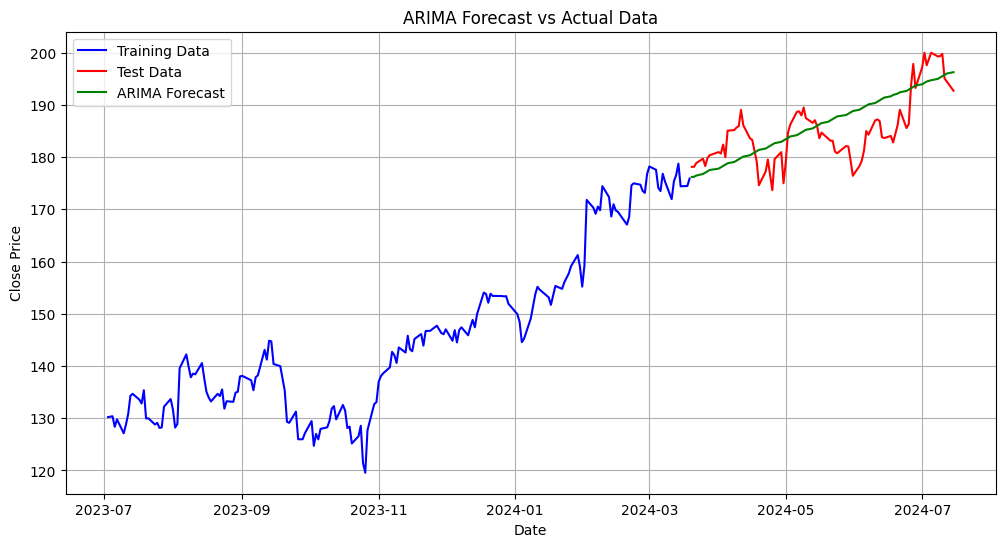

In [ ]:
arima_order = (2, 2, 1)  # ARIMA(p, d, q) order

# Fit ARIMA model
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

# Forecast the next 30 days
forecast_steps = len(test)  # Number of steps to forecast (length of test data)
arima_forecast = arima_fit.forecast(steps=forecast_steps)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='red')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Forecast vs Actual Data')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Get the best SARIMA order
best_sarima_order, best_sarima_rmse = best_sarima_order(train,test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values)
print(f"\nBest SARIMA order: {best_sarima_order} with RMSE: {best_sarima_rmse}")


SARIMA Results:
SARIMA(0, 0, 0, 0, 0, 0, 12) - RMSE: 185.13776946291267
SARIMA(0, 0, 0, 0, 0, 1, 12) - RMSE: 175.11251848268145
SARIMA(0, 0, 0, 0, 0, 2, 12) - RMSE: 167.40779943793893
SARIMA(0, 0, 0, 0, 1, 0, 12) - RMSE: 11.638381224471294
SARIMA(0, 0, 0, 0, 1, 1, 12) - RMSE: 11.68417236843651
SARIMA(0, 0, 0, 0, 1, 2, 12) - RMSE: 11.00069139289501
SARIMA(0, 0, 0, 1, 0, 0, 12) - RMSE: 12.561833393123104
SARIMA(0, 0, 0, 1, 0, 1, 12) - RMSE: 12.573173446637037
SARIMA(0, 0, 0, 1, 0, 2, 12) - RMSE: 12.142151741812059
SARIMA(0, 0, 0, 1, 1, 0, 12) - RMSE: 11.695520809721824
SARIMA(0, 0, 0, 1, 1, 1, 12) - RMSE: 11.974244654933187
SARIMA(0, 0, 0, 1, 1, 2, 12) - RMSE: 11.887914116688625
SARIMA(0, 0, 0, 2, 0, 0, 12) - RMSE: 12.576609988659467
SARIMA(0, 0, 0, 2, 0, 1, 12) - RMSE: 12.761367180625077
SARIMA(0, 0, 0, 2, 0, 2, 12) - RMSE: 13.026136601502188
SARIMA(0, 0, 0, 2, 1, 0, 12) - RMSE: 10.306928406936006
SARIMA(0, 0, 0, 2, 1, 1, 12) - RMSE: 11.322213235659415
SARIMA(0, 0, 0, 2, 1, 2, 12) - RM

# Sarima Model

In [ ]:
# 2. Forecast with best SARIMA model
sarima_model = SARIMAX(train, order=best_sarima_order[:3], seasonal_order=best_sarima_order[3:])
sarima_fit = sarima_model.fit(disp=False)



In [ ]:
# Forecast the next days
forecast_steps = len(test)  # Number of steps to forecast (length of test data)
sarima_forecast = sarima_fit.forecast(steps=forecast_steps)


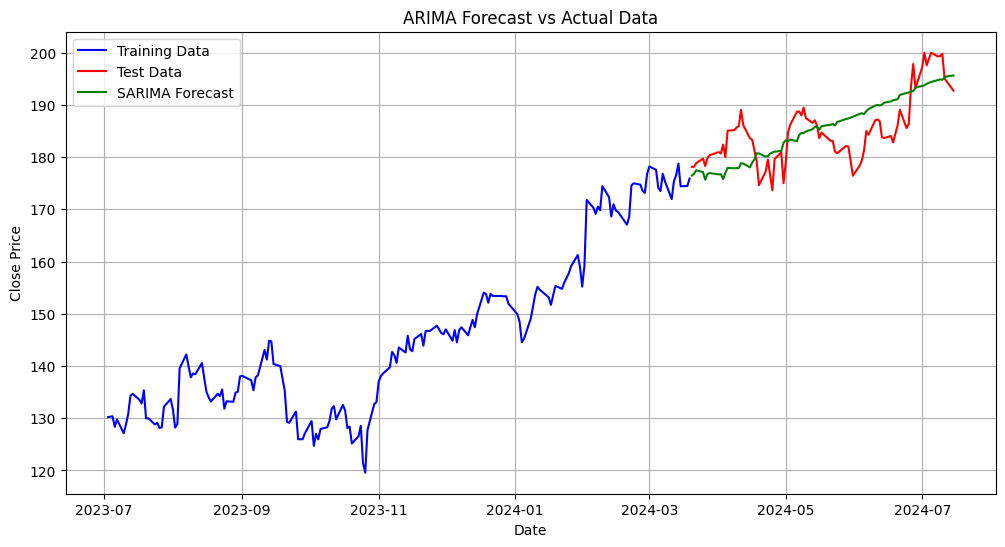

In [ ]:
# Plotting
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Forecast vs Actual Data')
plt.grid(True)
plt.legend()
plt.show()

# Next 30 Days Forecasting

In [ ]:
# Define the future dates for 30 days after the test period
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30, freq='D')


In [ ]:
# Forecast with ARIMA
arima_forecast = arima_fit.get_forecast(steps=30)
arima_forecast_mean = arima_forecast.predicted_mean
arima_conf_int = arima_forecast.conf_int()

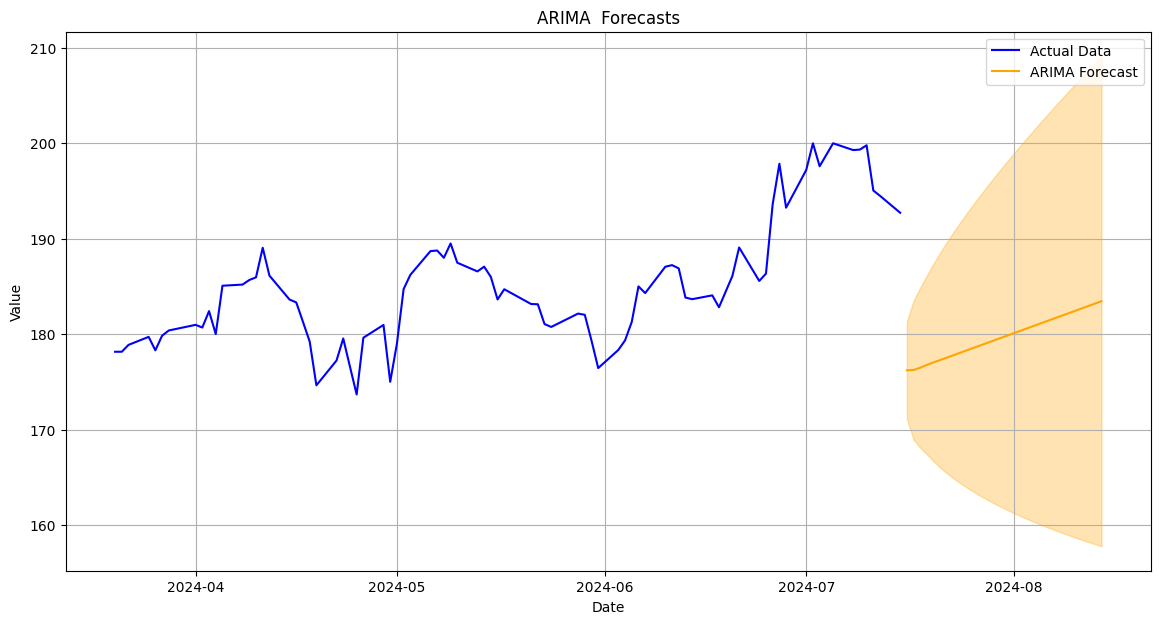

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA  Forecasts')
plt.grid(True)

plt.legend()
plt.show()


In [ ]:
# Forecast with SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=30)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()

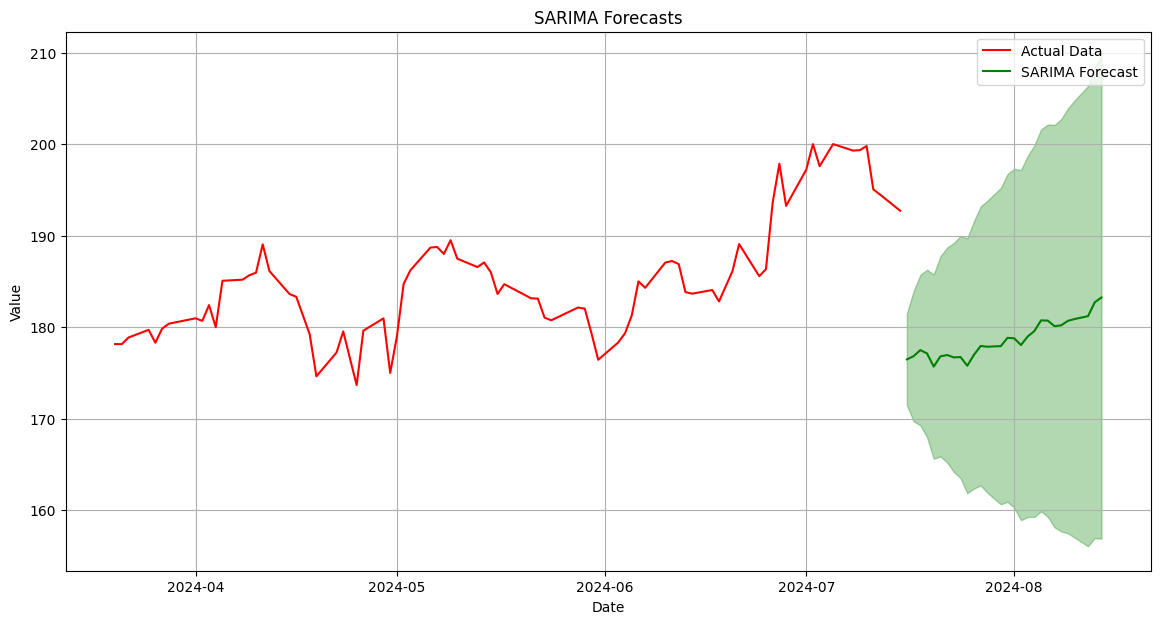

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='red')

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()


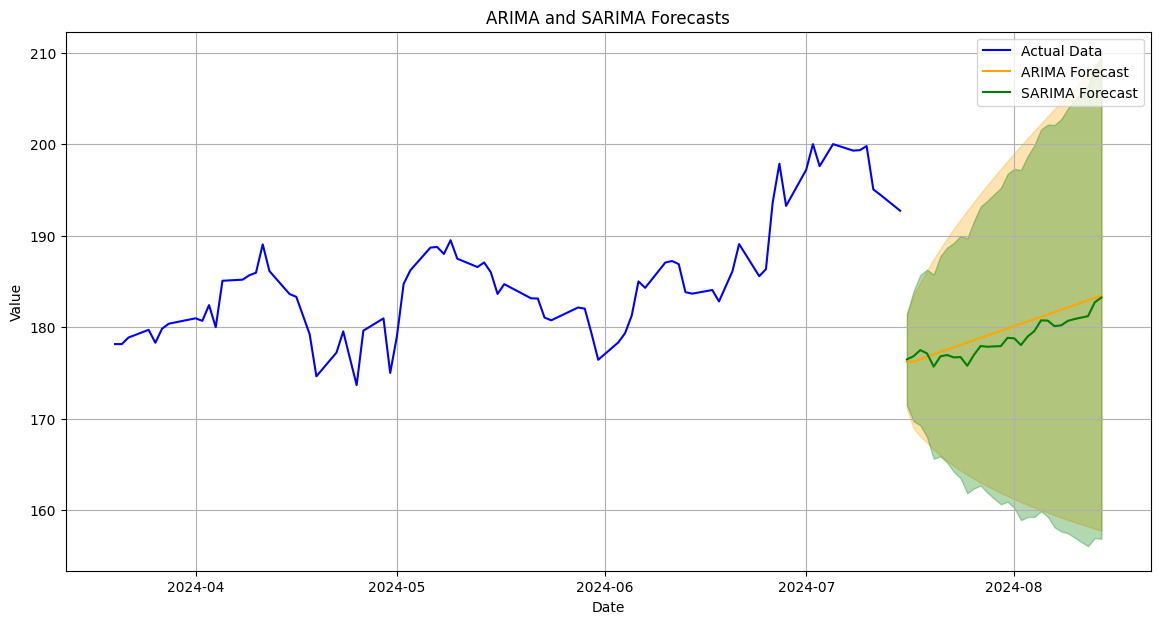

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()


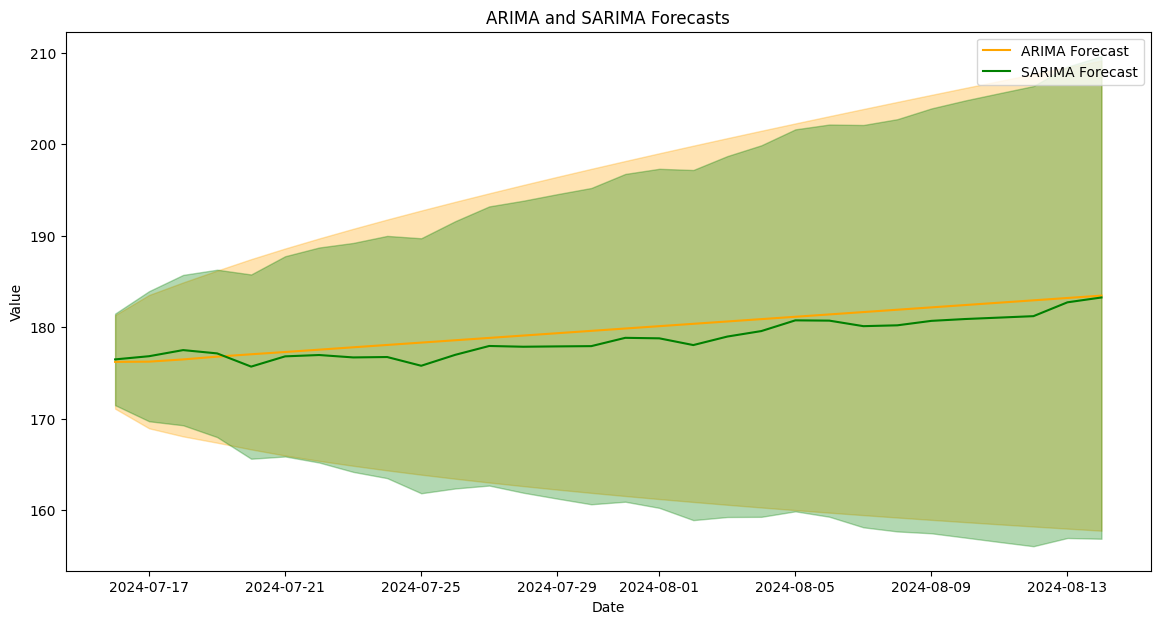

In [ ]:
plt.figure(figsize=(14, 7))

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.legend()
plt.show()


# Next 90 Days Forecasting

In [ ]:
# Define the future dates for 90 days after the test period
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=90, freq='D')

In [ ]:
# Forecast with ARIMA
arima_forecast = arima_fit.get_forecast(steps=90)
arima_forecast_mean = arima_forecast.predicted_mean
arima_conf_int = arima_forecast.conf_int()

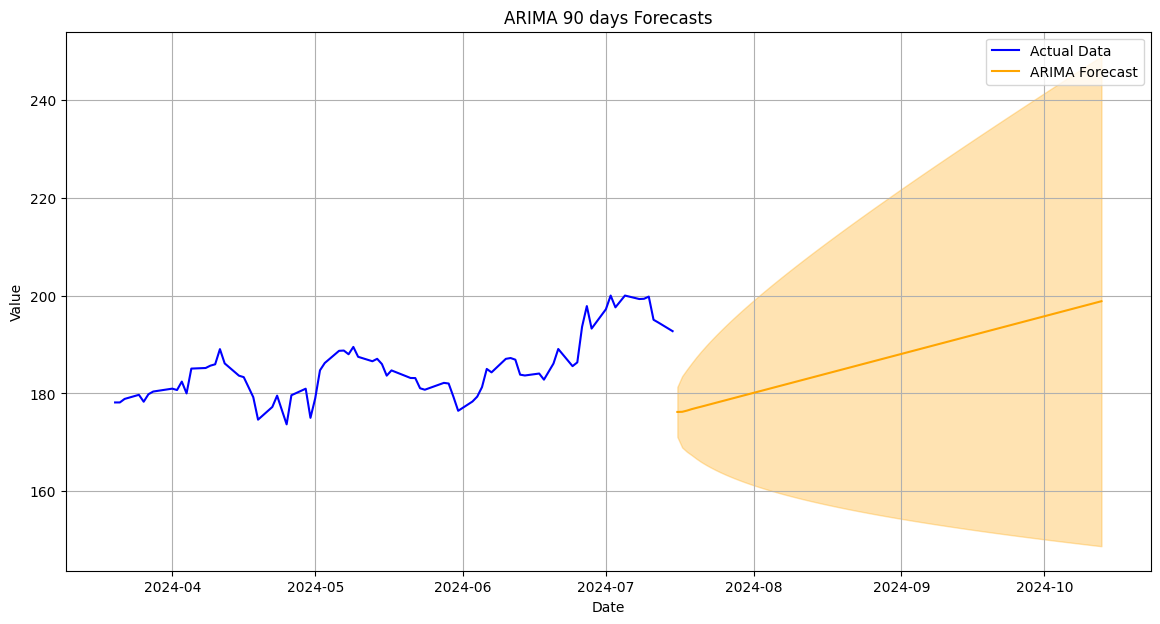

In [ ]:

plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA 90 days Forecasts')
plt.grid(True)

plt.legend()
plt.show()


In [ ]:
# Forecast with SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=90)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()

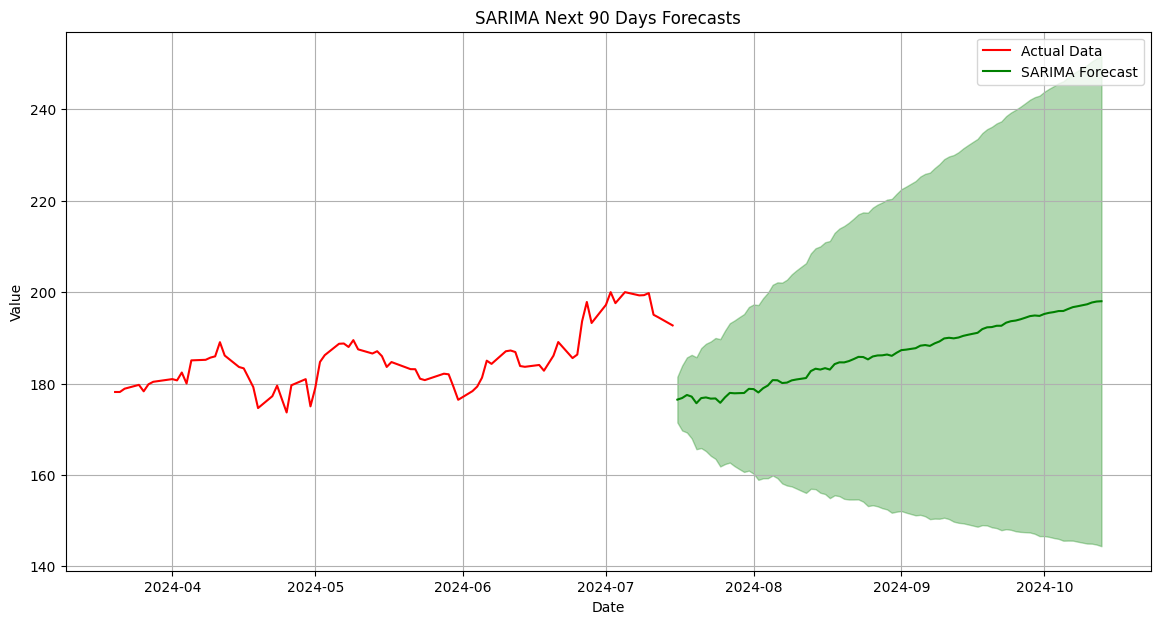

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='red')

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Next 90 Days Forecasts')
plt.grid(True)
plt.legend()
plt.show()


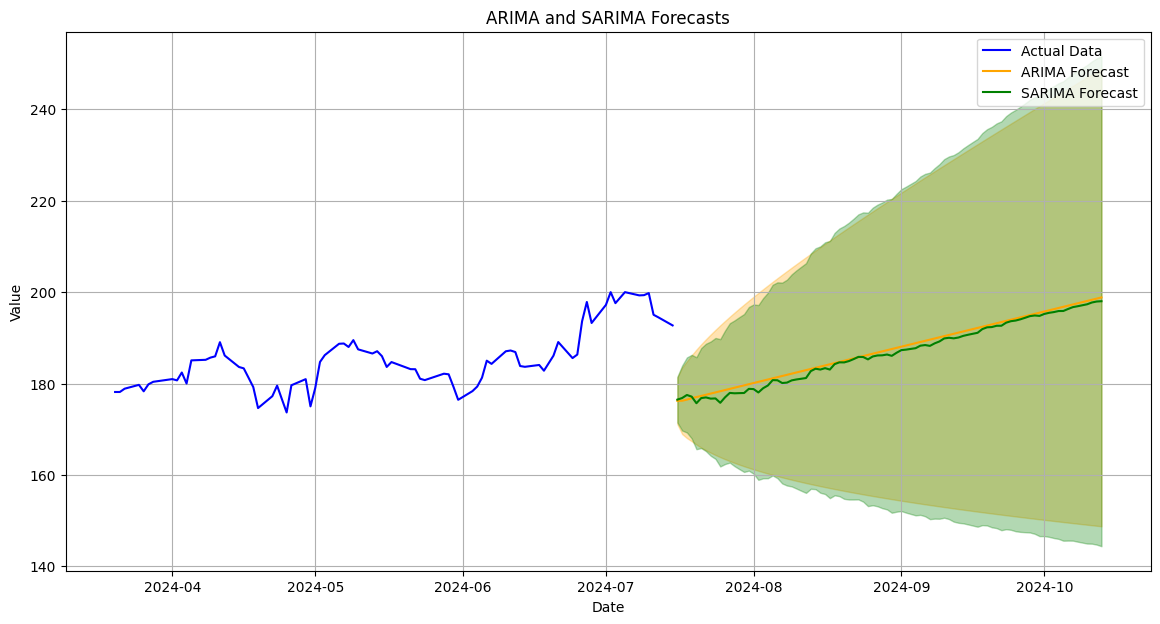

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()
